In [2]:
# Import standard libraries
from pathlib import Path

# import third-party libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt


In [ ]:
# Define constants
STANDARD_DEPTHS = np.array(
    [
        0,
        10,
        20,
        30,
        50,
        75,
        100,
        125,
        150,
        200,
        250,
        300,
        400,
        500,
    ]
)

In [5]:
DATA_DIR = Path("data")

In [ ]:
years = np.arange(1968, 2025, dtype=int)
months = np.arange(1, 13, dtype=int)
params = [
    "obs_dtm",
    "wtr_dep",
    "lon",
    "lat",
    "wtr_tmp",
    "sal",
    "dox",
    "qc_wtr",
    "qc_sal",
    "qc_dox",
    "sln_cde",
    "sta_cde",
]

In [ ]:
df_list = []
for year in years:
    for month in months:
        fname = f"sooList_{year}{month:02d}.json"
        file_path = DATA_DIR / fname
        if not file_path.exists():
            print(f"File {fname} does not exist. Skipping...")
            continue
        data = pd.read_json(file_path)
        df_list.append(
            pd.DataFrame(
                {
                    "observed_time": pd.to_datetime(data["obs_dtm"]),
                    "latitude": data["lat"],
                    "longitude": data["lon"],
                    "depth": data["wtr_dep"],
                    "temperature": data["wtr_tmp"],
                    "temperature_qc": data["qc_wtr"],
                    "salinity": data["sal"],
                    "salinity_qc": data["qc_sal"],
                    "dissolved_oxygen": data["dox"],
                    "dissolved_oxygen_qc": data["qc_dox"],
                    "line": data["sln_cde"],
                    "station": data["sta_cde"],
                }
            )
        )
if df_list:
    df = pd.concat(df_list, ignore_index=True)
else:
    df = pd.DataFrame(
        columns=[
            "observed_time",
            "latitude",
            "longitude",
            "depth",
            "temperature",
            "temperature_qc",
            "salinity",
            "salinity_qc",
            "dissolved_oxygen",
            "dissolved_oxygen_qc",
            "line",
            "station",
        ]
    )
print(f"Done. Dataframe shape: {df.shape}")

In [ ]:
ds = xr.Dataset(
    {
        "temperature": (["obs"], df["temperature"].values),
        "temperature_qc": (["obs"], df["temperature_qc"].values),
        "salinity": (["obs"], df["salinity"].values),
        "salinity_qc": (["obs"], df["salinity_qc"].values),
        "dissolved_oxygen": (["obs"], df["dissolved_oxygen"].values),
        "dissolved_oxygen_qc": (["obs"], df["dissolved_oxygen_qc"].values),
    },
    coords={
        "obs_time": (["obs"], df["observed_time"].values),
        "longitude": (["obs"], df["longitude"].values),
        "latitude": (["obs"], df["latitude"].values),
        "depth": (["obs"], df["depth"].values),
    },
)


In [ ]:
ds["temperature"].attrs["units"] = "Celsius"
ds["salinity"].attrs = {
    "units": "psu",
    "unit description": "Practical Salinity Unit",
}
ds["dissolved_oxygen"].attrs["units"] = "ml/L"


In [ ]:
ds.to_netcdf(DATA_DIR / "soolist_1968010120241231.nc")
print(f"Dataset saved to {DATA_DIR / 'soolist_1968010120241231.nc'}")

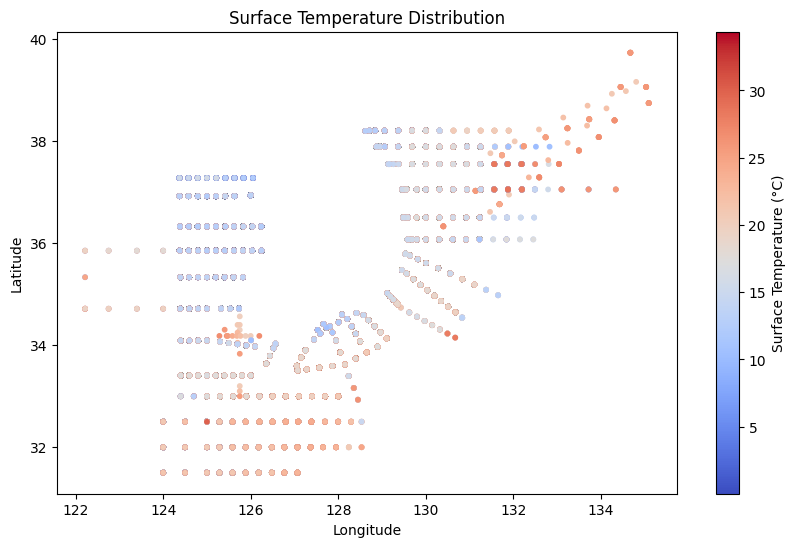

In [7]:
import iris

# Load the dataset using iris
iris_ds = iris.load(DATA_DIR / "soolist_1968010120241231.nc")

# Extract the temperature cube
temp_cube = iris_ds.extract_cube("temperature")

# Get the depth, longitude, latitude, and temperature data
depth = temp_cube.coord("depth").points
longitude = temp_cube.coord("longitude").points
latitude = temp_cube.coord("latitude").points
temperature = temp_cube.data

# Select surface (depth == 0) temperature
surface_mask = depth == 0
surface_lon = longitude[surface_mask]
surface_lat = latitude[surface_mask]
surface_temp = temperature[surface_mask]

plt.figure(figsize=(10, 6))
plt.scatter(
    surface_lon,
    surface_lat,
    c=surface_temp,
    cmap="coolwarm",
    s=10,
)
plt.colorbar(label="Surface Temperature (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Surface Temperature Distribution")
plt.show()